#### PRisk by NLP (using Hassan's run.score pipeline)

In [4]:
# Libraries

import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
os.chdir(homedir)
import seaborn as sns

In [3]:
# Change me
homedir = '.'

# Defining a strong path to firmlevelrisk/code 
expected_root = 'firmlevelrisk'
while expected_root not in os.listdir():
    os.chdir('..')
    
code_path = os.path.join('firmlevelrisk', 'code')
if code_path not in sys.path:
    sys.path.append(code_path)

import _helpers as h
import re
import pandas as pd

# Files
earningscall_dir = 'firmlevelrisk/input/earningscall_transcripts/'
output_dir = 'firmlevelrisk/output/'
sentimentwords_file = 'firmlevelrisk/input/sentimentwords/LoughranMcDonald_MasterDictionary_2018.csv'
riskwords_file = 'firmlevelrisk/input/riskwords/synonyms.txt'
polbigrams_file = 'firmlevelrisk/input/political_bigrams/political_bigrams.csv'


#-----------------------------#
# 1) Load auxiliary data sets #
#-----------------------------#
# Import positive and negative sentiment words, risk words, and collect all
sentiment_words = h.import_sentimentwords(sentimentwords_file)
risk_words = h.import_riskwords(riskwords_file)
allwords = dict(sentiment_words, **{'risk':risk_words})

# Import political bigrams
political_bigrams = h.import_politicalbigrams(polbigrams_file)

# SarsCov2-related words
sarscov2 = ['Coronavirus', 'Corona virus', 'coronavirus',
            'Covid-19', 'COVID-19', 'Covid19', 'COVID19',
            'SARS-CoV-2', '2019-nCoV']
sarscov2_words = set([re.sub('[^a-z ]', '', x.lower()) for x in sarscov2])


#---------------------------------------------#
# 2) Load and clean earnings call transcripts #
#---------------------------------------------#
# Parse text and metadata from HTML
transcripts_raw = h.load_transcripts(earningscall_dir)

# Preprocess text and return window of 22 consecutive bigrams
preprocessed = h.preprocess(transcripts_raw)


#----------#
# 3) Score #
#----------#
# Note: For illustrative purposes, I don't call any custom function

# Loop through transcripts
scores = {}
for title, content in preprocessed.items():
    
    print('Working on:', title)
    scores[title] = {}
    
    # Access preprocessed windows of consecutive bigrams
    windows = content['bigram_windows']
    words = content['cleaned']
    
    # Total number of words (to normalize scores)
    totalwords = len(words)
    
    ### A) Score unconditional scores
    risk = len([word for word in words if word in allwords['risk']])
    sentpos = len([word for word in words if word in allwords['positive']])
    sentneg = len([word for word in words if word in allwords['negative']])
    covid = len([word for word in words if word in sarscov2_words])
    
    # Collect and prepare for conditional scores
    scores[title] = {
        'Risk':risk,
        'Sentiment':sentpos-sentneg,
        'Covid':covid,
        'Pol':0,
        'PRisk':0,
        'PSentiment':0,
        'Total words':totalwords
        }
    
    ### B) Score conditional scores
    # Loop through each windows
    for window in windows:
    
        # Find middle ngram and check whether a "political" bigram
        middle_bigram = window[10]
        if middle_bigram not in political_bigrams:
            continue
        tfidf = political_bigrams[middle_bigram]['tfidf']
        
        # Create word list for easy and quick access
        window_words = set([y for x in window for y in x.split()])
        
        # If yes, check whether risk synonym in window
        conditional_risk = (len([word for word in window_words
                            if word in allwords['risk']]) > 0)
        
        # If yes, check whether positive or negative sentiment
        conditional_sentpos = len([word for word in window_words
                                   if word in allwords['positive']])
        conditional_sentneg = len([word for word in window_words
                                   if word in allwords['negative']])
        
        # Weigh by tfidf
        conditional_risk = conditional_risk * tfidf
        conditional_sentpos = conditional_sentpos * tfidf
        conditional_sentneg = conditional_sentneg * tfidf
        
        # Collect results
        scores[title]['Pol'] += tfidf
        scores[title]['PRisk'] += conditional_risk
        scores[title]['PSentiment'] += (conditional_sentpos-
                                                 conditional_sentneg)
        

# Collect in dataframe
scores_df = pd.DataFrame().from_dict(scores, orient='index')
scores_df.index.name = 'event name'

# Scale
toscale = [x for x in scores_df.columns if x not in {'Total words'}]
for column in toscale:
    scores_df[column] = scores_df[column]*100000*(1/scores_df['Total words']) # FYI: Normalization each 100k words

# Write
scores_df.to_csv(output_dir + 'earningscall_scores.tsv', sep='\t',
                 encoding='utf-8')

Working on 2023-Nov-02-CVGI.OQ-139635071723-Transcript.html
Working on 2022-Aug-15-FUVV.PK-137805303178-Transcript.html
Working on 2019-Aug-01-MOD.N-140533336808-Transcript.html
Working on 2021-May-12-BLBD.OQ-137922964577-Transcript.html
Working on 2022-Feb-28-XPEL.OQ-138214789423-Transcript.html
Working on 2022-Jul-26-GM.N-141162419632-Transcript.html
Working on 2023-Aug-08-WKHS.OQ-137851807231-Transcript.html
Working on 2023-Jul-27-FSS.N-139063885147-Transcript.html
Working on 2017-Jan-27-GNTX.OQ-140907406628-Transcript.html
Working on 2020-Feb-12-WNC.N-138095463914-Transcript.html
Working on 2021-Mar-10-CVGI.OQ-137988680967-Transcript.html
Working on 2023-May-09-BLNK.OQ-137478443751-Transcript.html
Working on 2017-Apr-25-WNC.N-140591555268-Transcript.html
Working on 2025-May-01-PATK.OQ-137417882041-Transcript.html
Working on 2024-Oct-30-MOD.N-138558858063-Transcript.html
Working on 2018-May-04-AXL.N-137428734470-Transcript.html
Working on 2021-May-06-MLR.N-138764118370-Transcript.ht

#### Descriptive Statistics

In [5]:
# Notes on sanity checks performed on July 29, 2025:

# Documents were correctly converted to HTML
# Documents were correctly extracted from HTML based on a correct modification/adaptation to helpers.py
# The PRisk A vs. B document has completely marginal differences. It was decided to continue the analysis with A
# With the assurance and peace of mind that A was indeed correctly calculated.

df = pd.read_csv('firmlevelrisk/output/earningscall_scores.tsv', sep='\t')
cols = ['Risk', 'Sentiment', 'Covid', 'Pol', 'PRisk', 'PSentiment']

# Descriptive statistics
desc = df[cols].describe(percentiles=[.25, .5, .75]).T
desc = desc[['mean', 'std', '25%', '50%', '75%']].round(2)

print(desc)


               mean      std      25%      50%      75%
Risk         341.81   100.10   272.60   332.90   398.81
Sentiment    628.76   486.39   320.78   636.00   954.03
Covid         19.94    51.60     0.00     0.00    13.18
Pol         6396.46  1479.34  5410.29  6102.55  7058.86
PRisk        400.96   206.15   268.35   363.68   491.40
PSentiment   738.97  1011.89   143.96   698.99  1284.74


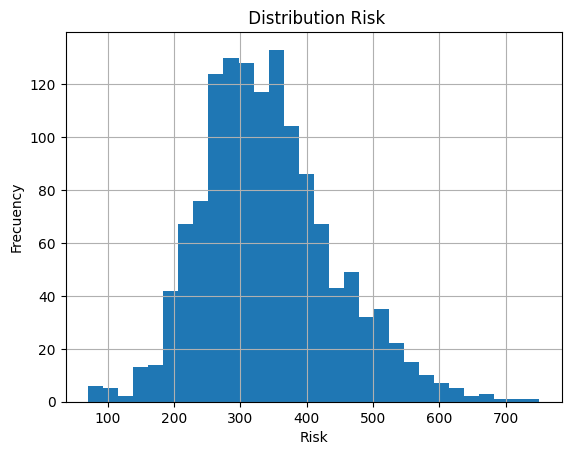

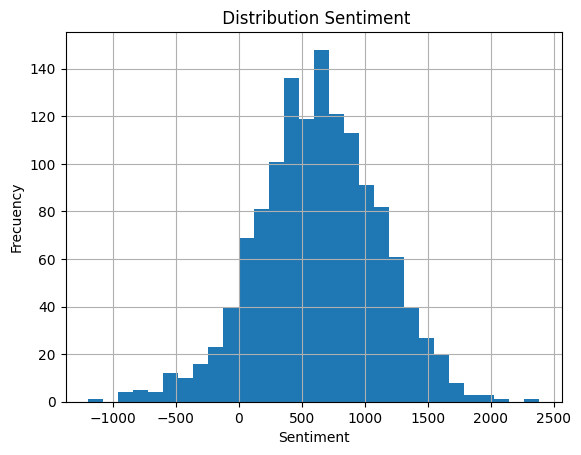

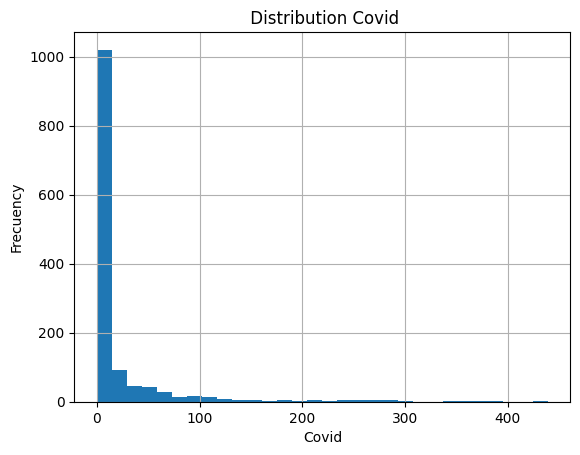

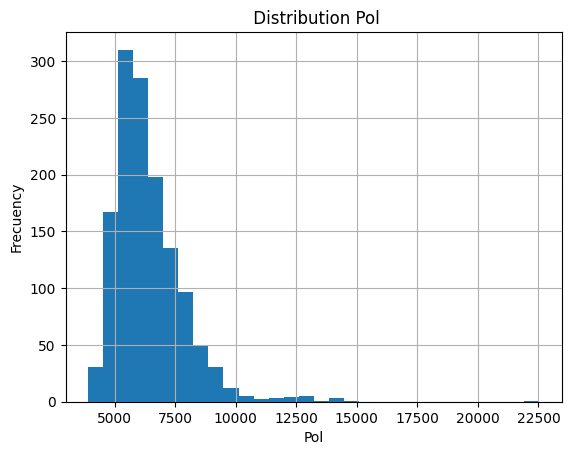

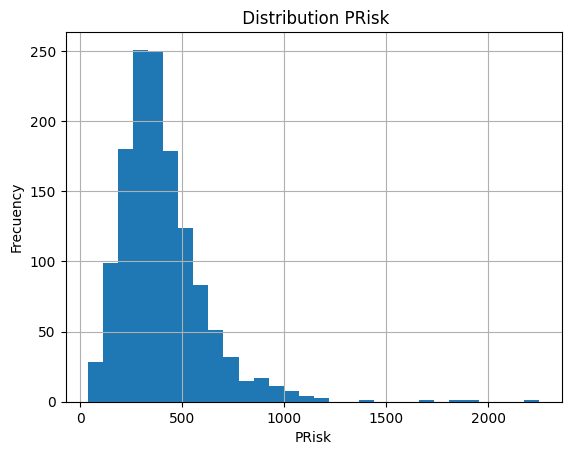

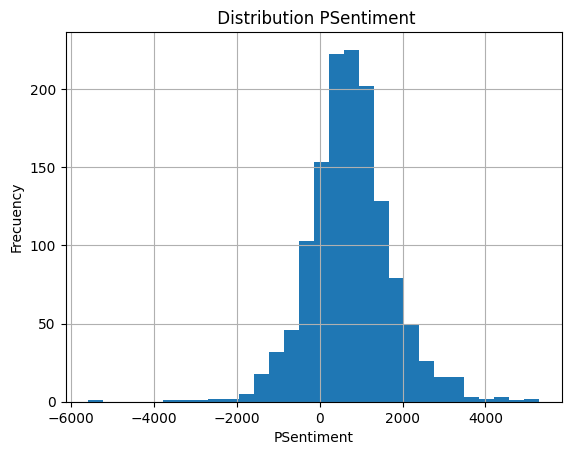

              Risk    Sentiment        Covid           Pol        PRisk  \
count  1340.000000  1340.000000  1340.000000   1340.000000  1340.000000   
mean    341.808068   628.761833    19.942785   6396.461856   400.955142   
std     100.098717   486.390773    51.604429   1479.343524   206.154990   
min      70.838253 -1195.335277     0.000000   3902.995409    39.252930   
25%     272.595997   320.777616     0.000000   5410.287454   268.348121   
50%     332.899160   635.995573     0.000000   6102.549458   363.683612   
75%     398.806429   954.027633    13.180474   7058.859661   491.398861   
max     750.469043  2382.601468   439.198463  22526.729421  2249.314213   

        PSentiment  
count  1340.000000  
mean    738.968359  
std    1011.893667  
min   -5592.327940  
25%     143.957714  
50%     698.987530  
75%    1284.740950  
max    5296.087042  
Risk          0
Sentiment     0
Covid         0
Pol           0
PRisk         0
PSentiment    0
dtype: int64


In [6]:
for col in cols:
    plt.figure()
    df[col].hist(bins=30)
    plt.title(f' Distribution {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuency')
    plt.grid(True)
    plt.show()

print(df[['Risk', 'Sentiment', 'Covid', 'Pol', 'PRisk', 'PSentiment']].describe())
print(df[['Risk', 'Sentiment', 'Covid', 'Pol', 'PRisk', 'PSentiment']].isna().sum())


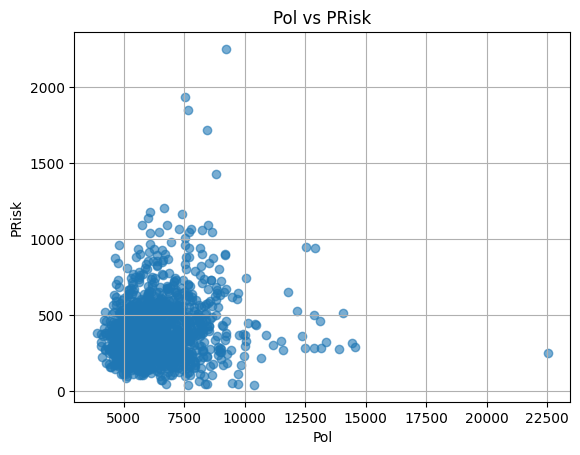

In [7]:
# Scatterplot Pol vs Prisk

plt.figure()
plt.scatter(df['Pol'], df['PRisk'], alpha=0.6)
plt.title('Pol vs PRisk')
plt.xlabel('Pol')
plt.ylabel('PRisk')
plt.grid(True)
plt.show()


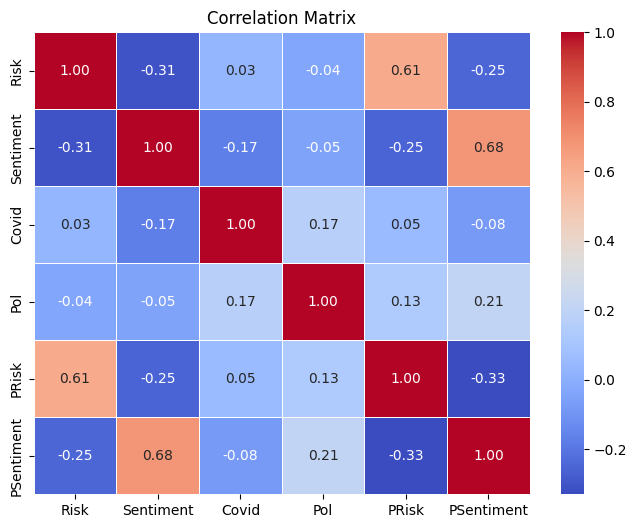

In [8]:
# Heatmap
cols = ['Risk', 'Sentiment', 'Covid', 'Pol', 'PRisk', 'PSentiment']
corr_matrix = df[cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


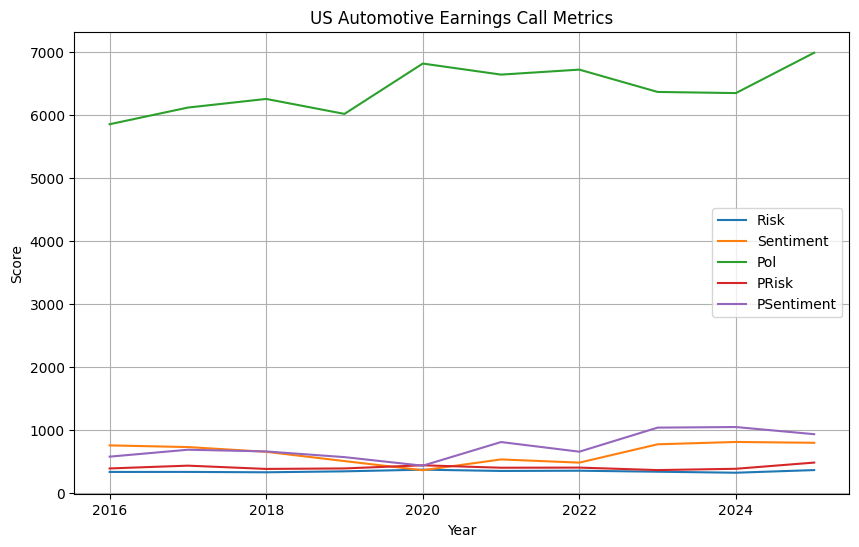

US Automotive Earnings Call Metrics:
            Risk   Sentiment          Pol       PRisk   PSentiment
Year                                                              
2016  333.397879  754.587614  5852.398855  388.715197   575.865446
2017  333.577520  728.111326  6117.301491  432.960344   685.675356
2018  327.532058  652.576319  6254.246763  381.076398   658.671366
2019  342.767686  505.606829  6016.590433  388.984821   568.270573
2020  369.218442  360.197959  6815.762547  438.837590   432.406080
2021  348.811771  531.776715  6640.385492  400.097041   807.751545
2022  352.633589  480.997716  6719.451153  402.099028   654.460406
2023  336.654463  771.893000  6365.172541  362.624830  1036.748940
2024  320.768317  809.121370  6347.010090  383.353480  1045.870012
2025  362.727394  795.933874  6987.760776  481.782852   932.365696


In [9]:
# U.S. Automotive Earnings Call Metrics

df = pd.read_csv('firmlevelrisk/output/earningscall_scores.tsv', sep='\t')
df.set_index('event name', inplace=True)
df['Year'] = df.index.str[:4].astype(int)
cols = ['Risk', 'Sentiment', 'Pol', 'PRisk', 'PSentiment']
yearly_avg = df.groupby('Year')[cols].mean()

plt.figure(figsize=(10, 6))
for col in cols:
    plt.plot(yearly_avg.index, yearly_avg[col], label=col)

plt.title('US Automotive Earnings Call Metrics')
plt.xlabel('Year')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

print("US Automotive Earnings Call Metrics:")
print(yearly_avg)

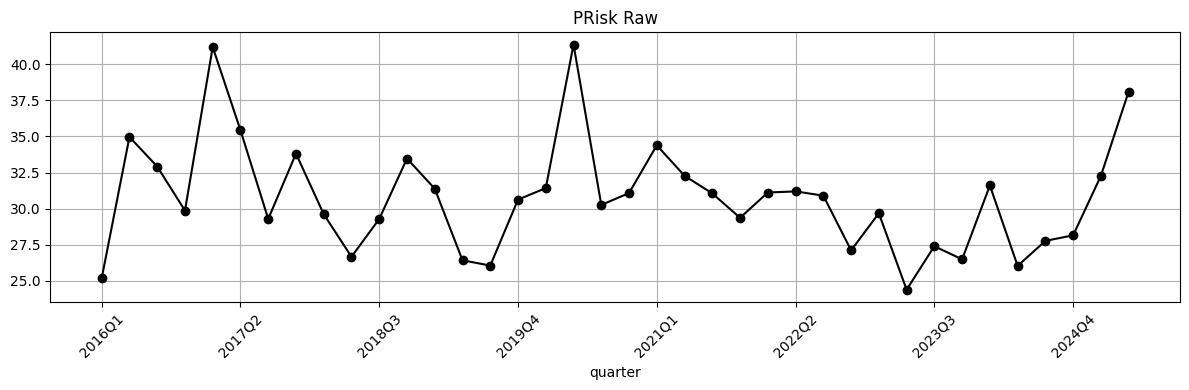

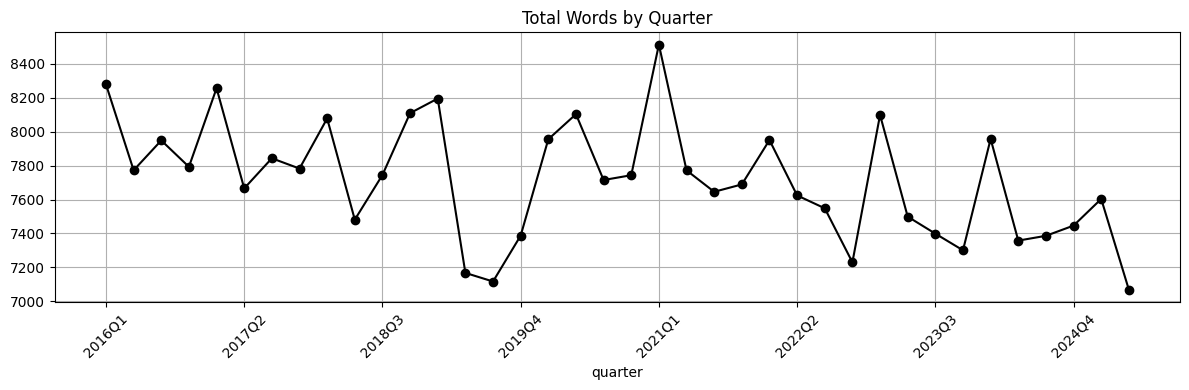

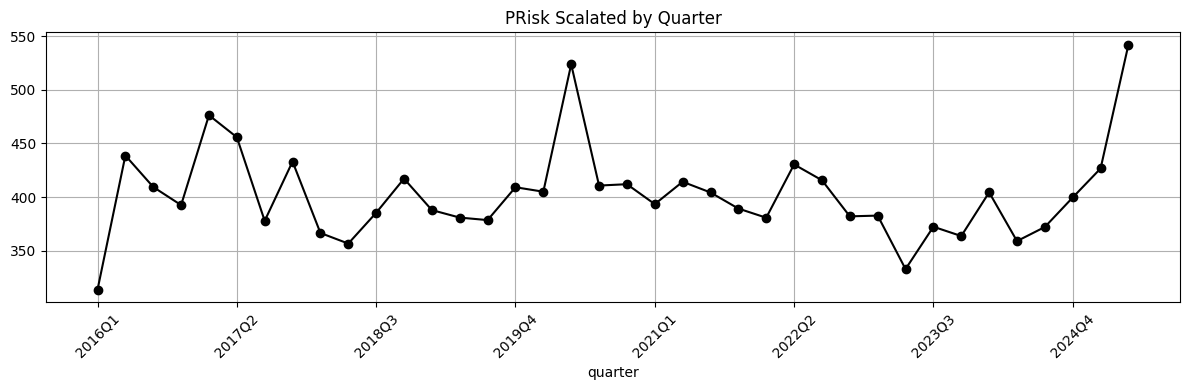

In [14]:
# PRisk Check
df = pd.read_csv('firmlevelrisk/output/earningscall_scores.tsv', sep='\t').reset_index()
df['date_str'] = df['event name'].str.extract(r'^(\d{4}-[A-Za-z]{3}-\d{2})')
df['date'] = pd.to_datetime(df['date_str'], format='%Y-%b-%d', errors='coerce')
df['quarter'] = df['date'].dt.to_period('Q').astype(str)

#print("\nQ Distribution Obs:")
#print(df['quarter'].value_counts().sort_index())

# PRisk raw
df['PRisk_raw'] = df['PRisk'] * df['Total words'] / 100000

# PRisk before Escalated
df.groupby('quarter')['PRisk_raw'].mean().plot(marker='o', color='black', figsize=(12, 4))
plt.title("PRisk Raw")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Total Words
df.groupby('quarter')['Total words'].mean().plot(marker='o', color='black', figsize=(12, 4))
plt.title("Total Words by Quarter")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Escalated Prisk
df.groupby('quarter')['PRisk'].mean().plot(marker='o', color='black', figsize=(12, 4))
plt.title("PRisk Scalated by Quarter")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
